Maximum Angular Deviation (Forward Euler): 0.20787 rad
Maximum Angular Deviation (Backward Euler): 0.12514 rad
Maximum Angular Deviation (RK4): 0.02041 rad


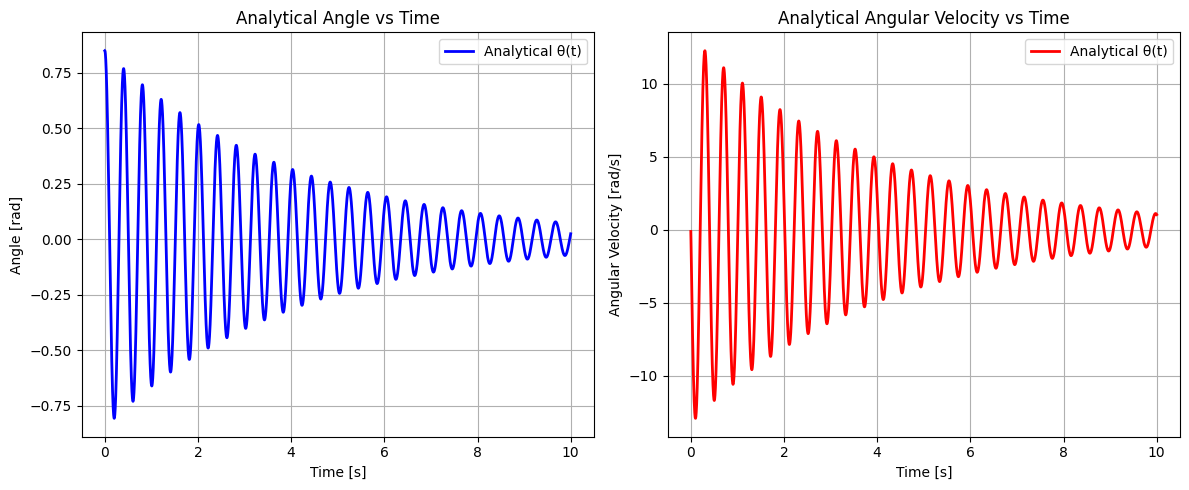

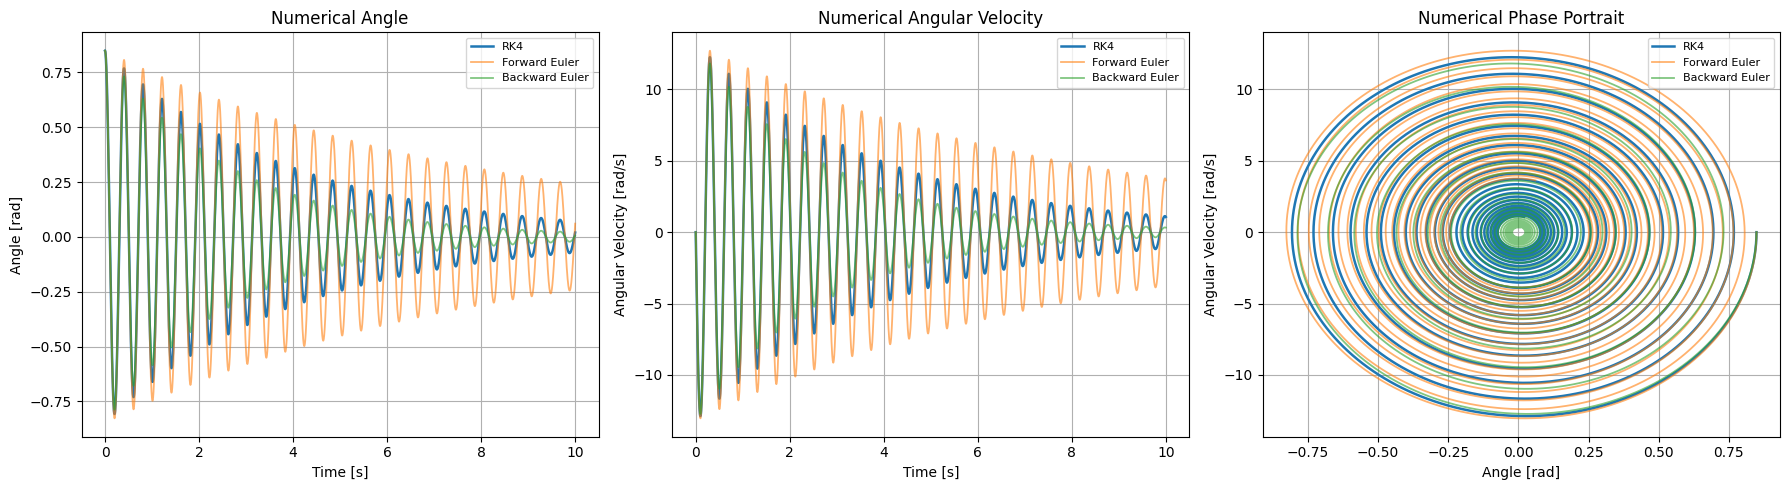


--- Maximum Angular Deviation Table ---
Method                   Max Error [rad]
Forward Euler                    0.20787
Backward Euler                   0.12514
RK4                              0.02041


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# System Parameters
# ===============================
m = 0.1       # kg
l = 0.9       # m
k = 18.8      # Nm/rad
b = 0.04      # Nm.s/rad
g = 9.81      # m/s^2

I = m * l**2
mgl = m * g * l
theta0 = 0.8482563619
theta_dot0 = 0.0
x0 = np.array([theta0, theta_dot0])

wn = np.sqrt((k + mgl) / I)             # Natural frequency
zeta = b / (2 * np.sqrt(I * (k + mgl))) # Damping ratio

Tf = 10.0
h = 0.001
t = np.arange(0, Tf+h, h)

# ===============================
# Nonlinear Dynamics
# ===============================
def pendulum_dynamics(x):
    theta, theta_dot = x
    theta_ddot = -(b/I)*theta_dot - (k/I)*theta - (mgl/I)*np.sin(theta)
    return np.array([theta_dot, theta_ddot])

# ===============================
# Numerical Methods
# ===============================
def forward_euler(fun, x0, Tf, h):
    t_vec = np.arange(0, Tf+h, h)
    x_hist = np.zeros((len(x0), len(t_vec)))
    x_hist[:,0] = x0
    for k in range(len(t_vec)-1):
        x_hist[:,k+1] = x_hist[:,k] + h * fun(x_hist[:,k])
    return x_hist, t_vec

def backward_euler(fun, x0, Tf, h, tol=1e-8, max_iter=100):
    t_vec = np.arange(0, Tf+h, h)
    x_hist = np.zeros((len(x0), len(t_vec)))
    x_hist[:,0] = x0
    for k in range(len(t_vec)-1):
        x_next = x_hist[:,k]
        for i in range(max_iter):
            f_val = fun(x_next)
            x_new = x_hist[:,k] + h*f_val
            if np.linalg.norm(x_new - x_next) < tol:
                break
            x_next = x_new
        x_hist[:,k+1] = x_next
    return x_hist, t_vec

def runge_kutta4(fun, x0, Tf, h):
    t_vec = np.arange(0, Tf+h, h)
    x_hist = np.zeros((len(x0), len(t_vec)))
    x_hist[:,0] = x0
    for k in range(len(t_vec)-1):
        k1 = fun(x_hist[:,k])
        k2 = fun(x_hist[:,k]+0.5*h*k1)
        k3 = fun(x_hist[:,k]+0.5*h*k2)
        k4 = fun(x_hist[:,k]+h*k3)
        x_hist[:,k+1] = x_hist[:,k] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return x_hist, t_vec

# ===============================
# Analytical Linear Solution (All Damping Cases)
# ===============================
def analytical_linear_all_cases(t):
    if zeta < 1:  # Underdamped
        wd = wn * np.sqrt(1 - zeta**2)
        A = theta0
        B = (theta_dot0 + zeta*wn*theta0)/wd
        theta = np.exp(-zeta*wn*t) * (A*np.cos(wd*t) + B*np.sin(wd*t))
    elif zeta == 1:  # Critically damped
        C1 = theta0
        C2 = theta_dot0 + wn*theta0
        theta = (C1 + C2*t) * np.exp(-wn*t)
    else:  # Overdamped
        r1 = -wn*(zeta - np.sqrt(zeta**2 - 1))
        r2 = -wn*(zeta + np.sqrt(zeta**2 - 1))
        C2 = (theta_dot0 - r1*theta0)/(r2 - r1)
        C1 = theta0 - C2
        theta = C1*np.exp(r1*t) + C2*np.exp(r2*t)
    theta_dot = np.gradient(theta, t[1]-t[0])
    return np.vstack((theta, theta_dot))

# ===============================
# Run Simulations
# ===============================
x_fe, t_fe = forward_euler(pendulum_dynamics, x0, Tf, h)
x_be, t_be = backward_euler(pendulum_dynamics, x0, Tf, h)
x_rk4, t_rk4 = runge_kutta4(pendulum_dynamics, x0, Tf, h)
x_lin = analytical_linear_all_cases(t_rk4)

# ===============================
# Compute Errors
# ===============================
error_fe = np.abs(x_fe[0,:] - x_lin[0,:])
error_be = np.abs(x_be[0,:] - x_lin[0,:])
error_rk4 = np.abs(x_rk4[0,:] - x_lin[0,:])

max_error_fe = np.max(error_fe)
max_error_be = np.max(error_be)
max_error_rk4 = np.max(error_rk4)

print(f"Maximum Angular Deviation (Forward Euler): {max_error_fe:.5f} rad")
print(f"Maximum Angular Deviation (Backward Euler): {max_error_be:.5f} rad")
print(f"Maximum Angular Deviation (RK4): {max_error_rk4:.5f} rad")

# ===============================
# FIGURE 1: Analytical Solution
# ===============================
plt.figure(figsize=(12,5))

# Analytical angle
plt.subplot(1,2,1)
plt.plot(t_rk4, x_lin[0,:], 'b', linewidth=2, label='Analytical θ(t)')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Analytical Angle vs Time')
plt.grid(True)
plt.legend()

# Analytical angular velocity
plt.subplot(1,2,2)
plt.plot(t_rk4, x_lin[1,:], 'r', linewidth=2, label='Analytical θ̇(t)')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Analytical Angular Velocity vs Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# ===============================
# FIGURE 2: Numerical Solutions
# ===============================
plt.figure(figsize=(18,5))

# Numerical angle
plt.subplot(1,3,1)
plt.plot(t_rk4, x_rk4[0,:], label='RK4', linewidth=1.8)
plt.plot(t_fe, x_fe[0,:], alpha=0.6, label='Forward Euler', linewidth=1.3)
plt.plot(t_be, x_be[0,:], alpha=0.6, label='Backward Euler', linewidth=1.3)
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Numerical Angle')
plt.legend(fontsize=8)
plt.grid(True)

# Numerical angular velocity
plt.subplot(1,3,2)
plt.plot(t_rk4, x_rk4[1,:], label='RK4', linewidth=1.8)
plt.plot(t_fe, x_fe[1,:], alpha=0.6, label='Forward Euler', linewidth=1.3)
plt.plot(t_be, x_be[1,:], alpha=0.6, label='Backward Euler', linewidth=1.3)
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Numerical Angular Velocity')
plt.legend(fontsize=8)
plt.grid(True)

# Numerical phase portrait
plt.subplot(1,3,3)
plt.plot(x_rk4[0,:], x_rk4[1,:], label='RK4', linewidth=1.8)
plt.plot(x_fe[0,:], x_fe[1,:], alpha=0.6, label='Forward Euler', linewidth=1.3)
plt.plot(x_be[0,:], x_be[1,:], alpha=0.6, label='Backward Euler', linewidth=1.3)
plt.xlabel('Angle [rad]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Numerical Phase Portrait')
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()
plt.show()





# ===============================
# Summary Table for Report
# ===============================
print("\n--- Maximum Angular Deviation Table ---")
print(f"{'Method':<20}{'Max Error [rad]':>20}")
print(f"{'Forward Euler':<20}{max_error_fe:>20.5f}")
print(f"{'Backward Euler':<20}{max_error_be:>20.5f}")
print(f"{'RK4':<20}{max_error_rk4:>20.5f}")
